In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [9]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
def sequential_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[1: ]))
  return dataset.batch(batch_size).prefetch(1)

class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    # clear the hidden states in the network: to make consecutive model calls independent
    self.model.reset_states()

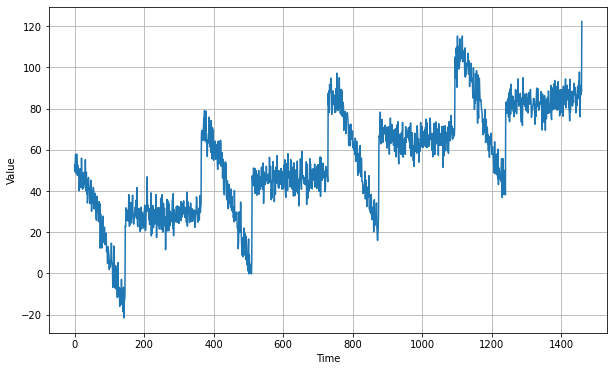

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)           
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30)
)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 26.4858 - mae: 26.9845 - lr: 1.0000e-07
Epoch 2/100
1/1 [==============================] - 0s 114ms/step - loss: 26.4726 - mae: 26.9712 - lr: 1.0798e-07
Epoch 3/100
1/1 [==============================] - 0s 59ms/step - loss: 26.4465 - mae: 26.9449 - lr: 1.1659e-07
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 26.4077 - mae: 26.9058 - lr: 1.2589e-07
Epoch 5/100
1/1 [==============================] - 0s 74ms/step - loss: 26.3565 - mae: 26.8543 - lr: 1.3594e-07
Epoch 6/100
1/1 [==============================] - 0s 61ms/step - loss: 26.2929 - mae: 26.7904 - lr: 1.4678e-07
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 26.2170 - mae: 26.7145 - lr: 1.5849e-07
Epoch 8/100
1/1 [==============================] - 0s 69ms/step - loss: 26.1288 - mae: 26.6266 - lr: 1.7113e-07
Epoch 9/100
1/1 [==============================] - 0s 68ms/step - loss: 26.0283 - mae: 26.5265 - lr: 1.84

(1e-07, 0.001, 0.0, 30.0)

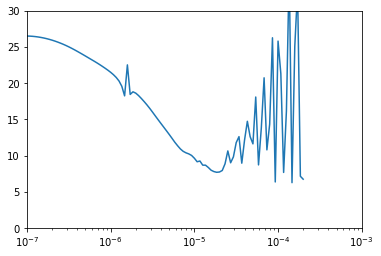

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-3, 0, 30])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size, batch_size=128)
valid_set = sequential_window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)           
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("conv_preprocess.h5", 
                                                      save_best_only=True)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=6e-6, momentum=0.9),
              metrics=["mae"])

model.fit(train_set, epochs=1000, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 85.4325 - mae: 85.9325 - val_loss: 101.8126 - val_mae: 102.3126
Epoch 2/1000
1/1 [==============================] - 0s 114ms/step - loss: 68.5480 - mae: 69.0480 - val_loss: 74.2715 - val_mae: 74.7715
Epoch 3/1000
1/1 [==============================] - 0s 117ms/step - loss: 44.8785 - mae: 45.3785 - val_loss: 41.8868 - val_mae: 42.3855
Epoch 4/1000
1/1 [==============================] - 0s 123ms/step - loss: 18.4422 - mae: 18.9337 - val_loss: 20.9472 - val_mae: 21.4383
Epoch 5/1000
1/1 [==============================] - 0s 101ms/step - loss: 24.9615 - mae: 25.4594 - val_loss: 24.9241 - val_mae: 25.4170
Epoch 6/1000
1/1 [==============================] - 0s 107ms/step - loss: 37.3499 - mae: 37.8478 - val_loss: 28.1571 - val_mae: 28.6550
Epoch 7/1000
1/1 [==============================] - 0s 103ms/step - loss: 42.7640 - mae: 43.2627 - val_loss: 24.7691 - val_mae: 25.2645
Epoch 8/1000
1/1 [==============================]

In [19]:
model = tf.keras.models.load_model("conv_preprocess.h5")

In [20]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : , np.newaxis]) # batch, time stamps, dim
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[0, split_time - 1: -1, 0]

1/1 [==============================] - 4s 4s/step
(1, 1461, 1)


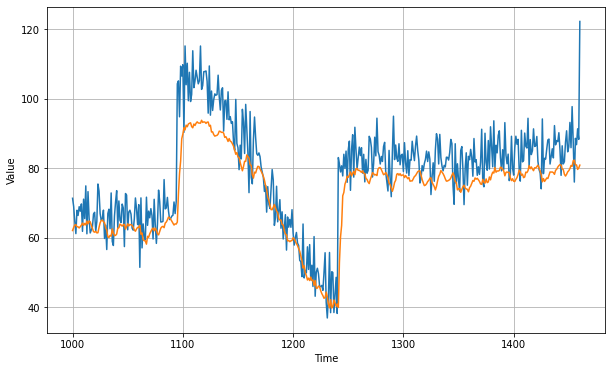

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.797924

In [ ]:
# WaveNet

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, 
                             dilation_rate=dilation_rate, padding="causal",
                             activation="relu")
  )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 30)
)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 42.6753 - mae: 43.1745 - lr: 1.0000e-05
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 42.6714 - mae: 43.1706 - lr: 1.0798e-05
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 42.6672 - mae: 43.1664 - lr: 1.1659e-05
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 42.6627 - mae: 43.1619 - lr: 1.2589e-05
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 42.6578 - mae: 43.1570 - lr: 1.3594e-05
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 42.6525 - mae: 43.1518 - lr: 1.4678e-05
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 42.6469 - mae: 43.1461 - lr: 1.5849e-05
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 42.6408 - mae: 43.1400 - lr: 1.7113e-05
Epoch 9/100
1/1 [==============================] - 0s 24ms/step - loss: 42.6342 - mae: 43.1334 - lr: 1.8478e-05
Epoch 

(0.0001, 0.1, 0.0, 30.0)

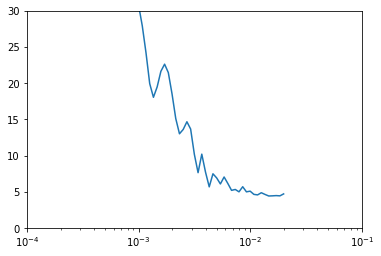

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, 
                             dilation_rate=dilation_rate, padding="causal",
                             activation="relu")
  )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))


early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("fully_conv.h5", 
                                                      save_best_only=True)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=["mae"])

model.fit(train_set, epochs=1000, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 42.6753 - mae: 43.1745 - val_loss: 77.2616 - val_mae: 77.7616
Epoch 2/1000
1/1 [==============================] - 0s 78ms/step - loss: 42.3150 - mae: 42.8144 - val_loss: 76.7142 - val_mae: 77.2142
Epoch 3/1000
1/1 [==============================] - 0s 75ms/step - loss: 42.0066 - mae: 42.5059 - val_loss: 76.1719 - val_mae: 76.6719
Epoch 4/1000
1/1 [==============================] - 0s 77ms/step - loss: 41.7050 - mae: 42.2044 - val_loss: 75.6065 - val_mae: 76.1065
Epoch 5/1000
1/1 [==============================] - 0s 79ms/step - loss: 41.3889 - mae: 41.8885 - val_loss: 74.9857 - val_mae: 75.4857
Epoch 6/1000
1/1 [==============================] - 0s 81ms/step - loss: 41.0455 - mae: 41.5451 - val_loss: 74.2897 - val_mae: 74.7897
Epoch 7/1000
1/1 [==============================] - 0s 81ms/step - loss: 40.6630 - mae: 41.1625 - val_loss: 73.4988 - val_mae: 73.9988
Epoch 8/1000
1/1 [==============================] - 0s 87

In [34]:
model = tf.keras.models.load_model("fully_conv.h5")

In [35]:
rnn_forecast = model.predict(series[np.newaxis, : , np.newaxis]) # batch, time stamps, dim
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[0, split_time - 1: -1, 0]

1/1 [==============================] - 0s 156ms/step
(1, 1461, 1)


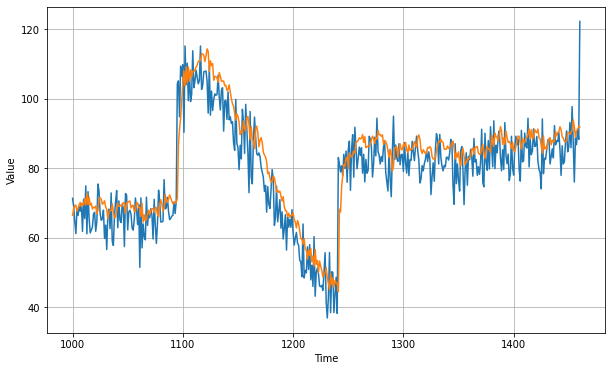

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.760452